# Lab 13:  K-Nearest Neighbors Regression

The *k-nearest neighbors* algorithm makes its predictions using the values of the k closest training data points.  For example, the 3-nearest neighbor algorithm will find the 3 closest data points (using the Euclidean distance) in the training data and use them to make a prediction.

If we are performing regression (trying to predict a quantitative value), the prediction is the mean of the y values of the k neighbors.

For this lab, we will use the building sale price data from Homework 9, which contains information about building sales in New York City from September 2016 to September 2017.  We will used the somewhat cleaned [version from Kaggle](https://www.kaggle.com/new-york-city/nyc-property-sales), which was originally taken from [New York City's Department of Finance Rolling Sales dataset](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page).

Data URL:  [https://raw.githubusercontent.com/megan-owen/MAT328-Techniques_in_Data_Science/main/data/nyc-rolling-sales.csv](https://raw.githubusercontent.com/megan-owen/MAT328-Techniques_in_Data_Science/main/data/nyc-rolling-sales.csv)

### Section 1: Loading and cleaning the data

First import the libraries we will use.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
    
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

pd.set_option('display.max_columns', None)

Load the data into the DataFrame `nyc`.  Missing values are stored as " -  " (a space, a a dash, and then two spaces) in the CSV file, so include the parameter to have Pandas convert them to Nan.

In [4]:
nyc = pd.read_csv("https://raw.githubusercontent.com/megan-owen/MAT328-Techniques_in_Data_Science/main/data/nyc-rolling-sales.csv", na_values=[" -  "])

<details><summary>Hint:</summary>
    Use the parameter `na_values = [" - "]` to have Pandas store the missing data as Nan.
    </details>
    
Display your DataFrame if you haven't already.

In [5]:
nyc

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.0,1900,2,C7,NaN,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.0,1900,2,C7,NaN,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,,10309,2,0,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,,10309,2,0,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,,10309,2,0,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,,10309,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0,2016-12-21 00:00:00


In this lab, we will try to predict the sales price from other information about the building.  Look at the columns - which do you think would not be helpful in determining the sales price or can not be easily used as/converted into quantitative data?  We will drop such columns.

Qualitative columns will need to be made into dummy variables, which could add a lot of new columns (ex. for the neighborhood column) and slow down computation speed.  So we are also balancing how many new columns will be added with how useful we think that information will be.  

Drop the following columns:
* "Unnamed: 0" (some kind of left-over index column?)
* "EASE-MENT" (seems empty for a lot of rows)
* "ADDRESS"  (could be helpful for determining the sales price, but we would have to do something further with it, such as extracting the street name)
* "APARTMENT NUMBER"  (empty for a lot of rows)
* "BLOCK" (could be helpful, but likely there are very few repeated values)
* "LOT" (lot numbers will be the same in different blocks, but that doesn't tell us anything about the property value)
* "TAX CLASS AT PRESENT" (we will keep the "TAX CLASS AT TIME OF SALE" instead, but an argument could be made to keep "TAX CLASS AT PRESENT" instead)
* "BUILDING CLASS AT PRESENT"  (we will keep the "TAX CLASS AT TIME OF SALE" instead, but an argument could be made to keep "BUILDING CLASS AT PRESENT" instead)


In [6]:
nyc.drop(['Unnamed: 0', 'EASE-MENT', 'ADDRESS', 'APARTMENT NUMBER', 'BLOCK', 'LOT', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT'], axis=1, inplace=True)

<details><summary>Hint:</summary>
Pattern for dropping multiple columns:
    <code>df.drop(columns = ["col1", "col2", "col3"], inplace = True)</code>
</details>

Next let's drop any rows with missing data.

In [10]:
nyc = nyc.dropna(how="any")

Check the length of the new DataFrame to make sure we still have enough data.

In [12]:
nyc.shape

(48244, 14)

Because both the sale price and gross square feet column have outliers (feel free to plot each as a histogram to verify), we will filter the data as in Homework 9 to remove these outliers.

First filter the DataFrame to only include sale prices between 20,000 and 2,000,000:

In [17]:
nyc = nyc.loc[(nyc['SALE PRICE'] <= 2000000) & (nyc['SALE PRICE'] >= 20000)]

Next filter the DataFrame to only include gross square feet greater than 0 or less than 6000 sq. ft.:

In [21]:
nyc = nyc.loc[(nyc['GROSS SQUARE FEET'] <= 6000) & (nyc['GROSS SQUARE FEET'] >= 0)]

The sale date might affect the sale price, but right now the `SALE DATE` column is not in a format that can be used to make predictions.  To change it to a usable format, we should:
* change the type of the column to a DateTime object
* create a new column containing only the month
* create a new column containing only the yera
* drop the `SALE DATE` column (as a DateTime type), since it still can't be used by scikit-learn

In [25]:
nyc['SALE DATE'] = pd.to_datetime(nyc['SALE DATE'])

<ipython-input-25-a1895dbb275f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc['SALE DATE'] = pd.to_datetime(nyc['SALE DATE'])


In [28]:
nyc["SALE YEAR"] = nyc["SALE DATE"].dt.year
nyc["SALE MONTH"] = nyc["SALE DATE"].dt.month

<ipython-input-28-f9d4337fa572>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc["SALE YEAR"] = nyc["SALE DATE"].dt.year
<ipython-input-28-f9d4337fa572>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc["SALE MONTH"] = nyc["SALE DATE"].dt.month


In [29]:
nyc = nyc.drop(columns=["SALE DATE"])

Finally, make most of the qualitative columns into dummy variables.  We will treat `MONTH` as a quantitative variable, under the assumption that sales in consecutive months are similar (though this will not cover the December-January).

Specifically, make the following columns into dummy variables: `"BOROUGH","NEIGHBORHOOD","BUILDING CLASS CATEGORY", "ZIP CODE", "TAX CLASS AT TIME OF SALE", "BUILDING CLASS AT TIME OF SALE"`

In [32]:
nyc = pd.get_dummies(nyc, columns = ["BOROUGH", "NEIGHBORHOOD", "BUILDING CLASS CATEGORY", "ZIP CODE", "TAX CLASS AT TIME OF SALE", "BUILDING CLASS AT TIME OF SALE"], drop_first = True)

How many columns does our new dataset have? 

In [33]:
nyc.shape

(33391, 524)



 It is ok that it is so large!  Part of what makes data science so powerful is that modern computers can quickly do computations even when we have a lot of variables.

### Section 2: K-Nearest Neighbors

First create a new DataFrame `x` with only the independent variables (every column except `SALE PRICE`).

In [40]:
x = nyc.drop(columns=["SALE PRICE"])

Also create a new Series `y` with only the dependent variable (`SALE PRICE`).

In [41]:
y = nyc["SALE PRICE"]

Split the `x` and `y` data into a training and testing set using `train_test_split()`.  Use a proportion of 0.2 of the data for test.

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

The following code creates a 7-nearest neighbor regressor object and fits it to our training data.

In [43]:
knn = KNeighborsRegressor(n_neighbors = 7)
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=7)

We can then use it to make predictions from our test data:

In [44]:
y_test_pred = knn.predict(x_test)

Compute the mean squared error of the test predictions.

In [45]:
mean_squared_error(y_test_pred, y_test)

111109473438.42299

<details><summary>Answer:</summary>
<code>mean_squared_error(y_test_pred, y_test)</code>
</details>

We'll compare this mean squared error (MSE) to the MSE of the training data to check for overfitting.

First predict `y` from the training data, and then compute its mean squared error.

In [46]:
y_train_pred = knn.predict(x_train)

How do the two mean squared error compare?  Do you think the model overfits the data?

Just as with linear regression, we can look for systematic error (error that has a pattern) by plotting the true `y` values of the test data on the x-axis against the error (true `y` values - predicted `y` values) on the y-axis.  Can you figure out the code to do this?

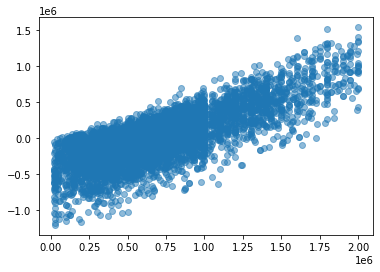

In [48]:
mean_squared_error(y_train_pred, y_train)

plt.scatter(y_test, y_test - y_test_pred, alpha = 0.5)

<details><summary>Answer:</summary>
<code>plt.scatter(y_test, y_test - y_test_pred, alpha = 0.5)</code>
</details>

Which prices are being under-estimated (the error is positive) by our model?  Which prices are being over-estimated (the error is negative) by our model?

### Section 3: Scaling

Notice that the values in some columns, like `LAND SQUARE FEET` and `GROSS SQUARE FEET`, are large, while the values in all the dummy variables columns are small (0 or 1).

When the columns have different scales, the largest column(s) will dominate.  We can get better results by scaling all of our columns to be between 0 and 1.  The scaling formula is:

$$x_{scaled} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$$

We can use a built in function in sci-kit learn to do the scaling.  First we make a scaler object.

In [49]:
scaler = MinMaxScaler()

And then we scale the training data.

In [50]:
x_train_scaled = scaler.fit_transform(x_train)

What does the scaled data look like?  Is this what you expect?

In [51]:
x_train_scaled

array([[0.05263158, 0.        , 0.00044228, ..., 0.        , 0.        ,
        0.        ],
       [0.05263158, 0.        , 0.00044228, ..., 0.        , 0.        ,
        0.        ],
       [0.05263158, 0.        , 0.00044228, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.10526316, 0.        , 0.00088456, ..., 0.        , 0.        ,
        0.        ],
       [0.05263158, 0.        , 0.00044228, ..., 0.        , 0.        ,
        0.        ],
       [0.10526316, 0.        , 0.00088456, ..., 0.        , 0.        ,
        0.        ]])

Scale your x test data.  We do not need to scale the y data.

In [53]:
x_test_scaled = scaler.fit_transform(x_test)

Create and fit a 7-nearest neighbor regressor with the scaled training data.

In [54]:
knn = KNeighborsRegressor(n_neighbors = 7)
knn.fit(x_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=7)

Use this new model to make predictions from the scaled test data.

In [59]:
y_test_pred = knn.predict(x_test_scaled)

Compute the mean squared error for these predictions.  Does scaling improve the 3-7earest neighbor regressor?

In [60]:
mean_squared_error(y_test_pred, y_test)

68041072065.84567

### Section 4:  Parameter search

In k-nearest neighbors, k is called a *parameter* (similar to the parameters we pass into our code functions).  We can try to figure out the best k to use by trial and error, but it might be easier to systematically try all values of k in some range.

Thus, we will write a loop to try all values of k between 1 and 20, and compute the mean squared error for each one.  The pseudo-code to do this is:

<code>
create an empty list
loop k from 1 to 20:
    create a k-nearest neighbor regressor
    fit the training data to the k-nearest neighbor regressor
    make predictions for the test data
    compute the mean squared error for the predictions
    store the mean squared error in the list
</code>

The code will take some time to run.  It will take longer to run for large k, so you can reduce the time by searching a smaller range of possible k's.

In [ ]:
mses = []
for k in range(1,21):
    print("Now computing MSE for k=",k)
    iknn_scaled = KNeighborsRegressor(n_neighbors = k)
    iknn_scaled.fit(x_train_scaled, y_train)
    iy_pred_scaled = iknn_scaled.predict(x_test_scaled)
    mse = mean_squared_error(iy_pred_scaled, y_test)
    mses.append(mse)

Now computing MSE for k= 1
Now computing MSE for k= 2
Now computing MSE for k= 3
Now computing MSE for k= 4
Now computing MSE for k= 5
Now computing MSE for k= 6
Now computing MSE for k= 7
Now computing MSE for k= 8
Now computing MSE for k= 9
Now computing MSE for k= 10
Now computing MSE for k= 11
Now computing MSE for k= 12
Now computing MSE for k= 13
Now computing MSE for k= 14
Now computing MSE for k= 15
Now computing MSE for k= 16
Now computing MSE for k= 17


We can plot these mean squared errors as a line plot, to understand how increasing k changes the MSE.

In [1]:
plt.plot(mses)
plt.xlabel("k")
plt.ylabel("MSE")
plt.title("MSE for different numbers of neighbors")

NameError: name 'plt' is not defined

How do the mean squared errors change?  What k would you choose?  What other information would help you make this choice?